## Introduction

This notebook shows the implementation of the *Project 1* of the HS25 cohort of the NLP course at HSLU.

The task was to answer single-choice questions from the commonsenseQA dataset using two different architectures:
* A simple 2-layer classifier with RELU-nonlinearity
* A 2-layer GRU or LSTM followed by a 2-layer classifier with RELU-nonlinearity

All code implementations can be found in this notebook. Experiments have been tracked using *wandb* and their results are shown in a wandb [project report](https://api.wandb.ai/links/david-schurtenberger/kcematxe)

## Setup

#### Install dependencies

* **torch**: PyTorch framework for the creation of neural networks
* **lightning**: Lightning wrapper for pytorch for simple network training
* **huggingface_hub**: HuggingFace hub for downloading word vectors
* **datasets**: HuggingFace datasets to download and load the data set
* **wandb**: Weights & Biases for experiment tracking
* **fasttext**: Word embedding library
* **nltk**: Natural Language Toolkit used for word tokenization
* **torchmetrics**: Extension to lightning to compute model metrics
* **matplotlib**: Display confusion matrix plot
* **pandas**: Create error analysis in tabular format

In [1]:
import sys

%pip install -q torch lightning huggingface_hub datasets wandb nltk torchmetrics matplotlib pandas

if sys.platform == 'win32': # Windows requires different fasttext implementation
    %pip install -q fasttext-wheel
else: 
    %pip install -q fasttext

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Do all the imports needed in this project, but keep them separate depending on the part of the notebook that uses them. Reason: Makes reading easier in later sections if done subsequently, but don't users to import everything if they just want to run some specific cells

##### pytorch & lightning

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import lightning as L
from lightning.pytorch.loggers import WandbLogger
import torchmetrics

##### Huggingface

In [3]:
from huggingface_hub import hf_hub_download
from datasets import Dataset as HFDataset
from datasets import load_dataset

##### Tokenization & Embeddings

In [4]:
import nltk
import fasttext

##### Evaluation

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

##### Python Builtins

In [6]:
from typing import Callable
import time

##### Experiment Tracking

In [7]:
import wandb

#### Load dataset

Use the pre-defined method to load the dataset and do the train and validation split

In [8]:
train: HFDataset = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid: HFDataset = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test: HFDataset = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


#### Setup Weights & Biases

Login to weights and biases to enable experiment tracking

In [9]:
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: schurtenberger-david (david-schurtenberger) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Preprocessing

#### Vocabulary/Embedding

* I used **FastText** word embeddings. Reason:

    * Mentioned in class that FastText is superior to other embedding models
    * Can handle unknown words, due to subword embeddings

* I will be working with the [Facebook English Fasttext embeddings](https://huggingface.co/facebook/fasttext-en-vectors). Reason:

    * They are directly downloadable from *HuggingFace hub*
    * The embed words from the English language, which is the scope of this project

* This choice influences decisions in the following pre-processing steps.

#### Format cleaning (e.g. html-extracted text)

* No format cleaning is performed. Reason:
    
    * We are working with a carefully assembled and standardized dataset used in model benchmarking

#### Tokenization

* *word_tokenizer* from the **nltk** library will be used. Reason:

    * Works well for the English language
    * It splits punctuation from text, which matches the tokens the fasttext word vectors were trained on

#### Lowercasing, stemming, lemmatizing, stopword/punctuation removal

* **Lowercasing**: Tokenized words are lower-cased. Reason:

    * Keep vocabulary small
    * The FastText model from facebook was trained on uppercase, so it could handle uppercased words, but using lower-cased also minimized out-of-vocabulary words

* **Stemming**: No stemming is used. Reason:

    * The embedding model was not trained on word stems and therefore no stemming is carried out
    
* **Lemmatizing**: The word tokens to be embedded will not be lemmatized. Reason:
 
    * The embedding model was trained on un-lemmatized words 
    * The n-gram encoding of the words used in fasttext preserves sub-word information

* **Stopword/Punctudation removal**: No stopword, punctuation removal. Reason:

    * Stopwords and punctuation can be crucial for question answering
    * Questions are short, therefore minimize loss of information

#### Removal of unknown/other words

* No unknown or other words are removed. Reason:

    * FastText can build embeddings from a words n-gram vectors
    * The encounter of unknown words is not expected

#### Truncation

* Input will not be truncated. Reason:

    * Longest question yields an embedded tensor of shape **67x300**
    * Depending on input format, the processing of a little over 67 timesteps is deemed to be feasible

#### Feature selection

* **question**, **choices** and **answerKey** were selected. Reason:

    * *questionConcept* seemed interesting, but this feature often simply contains a word from the question
    * The end this feature was left out in order not to give too much emphasis to a single word that does likely not help answering the question at all

#### Input format: how is data passed to the model?

###### Classifier

* Tensor with shape **(1800,)**.

* The first 300 elements are the averages of the embedded question tokens, next are 300 elements for every embedded and averaged answer vector from answer option 'A' to 'E'. Reason:
    
    * Average of question vectors, because it is a good tradeoff between information retention and input  dimension for the classifier
    * Question vector is before answer vectors because "Q&A" also has question first, then answers
    * Answers are arranged from 'A' to 'E' because of alphabetical order
    * Average of the answer embeddings because answers can consist of multiple words and may yield multiple embedding vectors

###### RNN + Classifier

* Tensor with shape **(5, N + 2, 300)**

* The average of the answer embeddings, are concatenated to the question with sequence length *N* with a separator token in between. Reason:

    * Question preprended to every answer because every resulting hidden vector has the same amount of question and answer encoded
    * Average of answer embeddings because every choice has the same amount of time steps in answer encoding
    * Separator token from character **¦** because model can learn when question stops and answer start and character is not used in dataset
    * Answer embeddings after question embeddings, because "Q&A" also has question first, then answer.    

#### Label format: what should the model predict?

* Tensor with shape **(5,)**. Reason:

    * Answers choices ('A' through 'E') are encoded on an index in the vector (0 through 4)
    * Classifier at last model step predicts likelihood of each class/choice

#### Train/valid/test splits

* Last *1000* entries of train set are validation set. Validation set is test set. Reason:

    * Required in assignment

#### Batching, padding

* Batch size is **512** (both architectures). Reason:

    * Experimentation showed that both datasets fully fit on GPU memory on *gpuhub*
    * Choose *512* as batch size to keep doing stochastic gradient descent
    * *gpuhub* does not always allocate same amount of GPU memory, but batch size *512* never used more than 80% of allocated memory

* During training at one point there were suddenly *CUDA memory errors* encountered, this is why the batch size for the *RNN+Classifier* model has been dropped to **256** for the remaining runs. 

* No padding for *Classifier* model. Reason:

    * Input is always of the same size
    
* Padding to maximum sequence length of batch for *RNN+Classifier* model. Reason:

    * Question tensors are of variable length
    * Same sequence length needed for every tensor of a batch, to compute one single tensor
    * Padded tensor can be packed to keep parallel processing on GPU without executing timesteps for padding vectors
    * Implemented in **rnn_collate_fn**

### Tokenize

Create method to tokenize and lowercase a given text

In [10]:
nltk.download("punkt_tab")

def tokenize(text: str) -> list[str]:
    return [w.lower() for w in nltk.word_tokenize(text, language="english")]

[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Word embeddings

Download the english fasttext word vectors and load their model into the variable *wv_model*

Create a function to embed a list of tokenized words and return them as a list of pytorch tensors

In [11]:
model_path = hf_hub_download("facebook/fasttext-en-vectors", "model.bin")
wv_model = fasttext.load_model(model_path)

def get_embeddings_for_tokens(tokens: list[str]):
    return torch.stack([torch.tensor(wv_model[t]) for t in tokens])
    

### Data Loading and Formatting



Introduce a type for functions that transform question and answer tensors into combined tensors for both model architectures

In [12]:
TransformMethod = Callable[[torch.Tensor, list[torch.Tensor]], torch.Tensor]

Create a separator token from a character that is known to the word vector model, but unused in the train, valid and test datasets 

In [13]:
def char_not_in_huggingface_dataset(char: str, dataset: HFDataset) -> bool:
    for datapoint in dataset:
        if char in datapoint["question"] or any(char in c for c in datapoint["choices"]["text"]):
            return False
    return True
    

separator = "¦"
assert separator in wv_model # Check if placeholder is a known token in the model
assert char_not_in_huggingface_dataset(separator, train)
assert char_not_in_huggingface_dataset(separator, valid)
assert char_not_in_huggingface_dataset(separator, test)

SEP_TOKEN = torch.tensor(wv_model[separator])
SEP_TOKEN.shape

torch.Size([300])

Create a **pytorch** *Dataset* class in which the HuggingFace dataset is loaded and preprocessed. This allows for an easy integration with a *DataLoader* afterward.

In [14]:
KEY_INDEX_MAPPING = {
    "A": 0,
    "B": 1,
    "C": 2,
    "D": 3,
    "E": 4,
}

class CommonsenseQADataset(Dataset):    
    def __init__(self, dataset: HFDataset, transform: TransformMethod):
        self.dataset: list[dict[str, torch.tensor | list[torch.tensor]]] = []
        self._target_transform = transform
        self._transform_hugging_face_dataset(dataset)
    
    def _transform_hugging_face_dataset(self, dataset: HFDataset):
        self.dataset.extend([{
            "feature": self._target_transform(
                get_embeddings_for_tokens(tokenize(entry["question"])),
                [get_embeddings_for_tokens(tokenize(choice)) for choice in entry["choices"]["text"]],
            ),
            "label": torch.tensor(KEY_INDEX_MAPPING[entry["answerKey"]]),
        } for entry in dataset])
        if len(self.dataset) != len(dataset):
            raise RuntimeError("Converted dataset is not full reflection of source data")
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        data_point = self.dataset[idx]
        return data_point["feature"], data_point["label"]

Transform function for **Classifier** architecture

* Function input: Question-tensor (N, 300) and answer-tensor (5, 300)
* Function output: Classifier-tensor (1800,)
    * Average of question vectors yields tensor with shape (300,)
    * Question vector and answer vectors are concatenated (300,) + (5, 300) = (1800,)

In [15]:
def classifier_target_transform(question: torch.Tensor, answers: list[torch.Tensor]) -> torch.Tensor:
    return torch.cat((question.mean(dim=0), *(a.mean(dim=0) for a in answers)))

Transform function for **RNN + Classifier** architecture

* Function input: Question-tensor (N, 300) and answer-tensor (5, 300)
* Function output: RNN-tensor (5, N + 2, 300) with N question vectors, 1 SEP_TOKEN vectors separating the question from the answer and 1 answer vector. For every answer individually

In [16]:
def rnn_target_transform(question: torch.Tensor, answers: list[torch.Tensor]) -> torch.Tensor:
    concatenated = [torch.cat((question, SEP_TOKEN.unsqueeze(0), answer.mean(dim=0).unsqueeze(0))) for answer in answers]
    return torch.stack(concatenated, dim=0)

Collate function for **RNN + Classifier** architecture

* Function input: List of length *batch_size* (*B*) of tuples of transformed tensors and labels
    * Shape transformed tensors (5, S, 300) (S = sequence length)
* Function output: Forward-tensor (B, 5, MAX_S, 300)
    * Unsorted for later semantic evaluation, but with lenghts so sequence can be sorted for *pack_padded_sequence*

In [17]:
def rnn_collate_fn(batch: list[tuple[torch.Tensor, torch.Tensor]]):
    questions, labels = zip(*batch)

    lengths = torch.tensor([q.shape[1] for q in questions])
    max_len = lengths.max()
    padded_questions = torch.stack(
        [torch.nn.functional.pad(q, (0, 0, 0, max_len - l)) for q, l in zip(questions, lengths)])

    labels = torch.stack(labels)

    return padded_questions, lengths, labels

Transform HuggingFace datasets to pytorch Datasets for both Classifier and RNN+Classifier models

In [18]:
train_classifier = CommonsenseQADataset(train, classifier_target_transform)
valid_classifier = CommonsenseQADataset(valid, classifier_target_transform)
test_classifier = CommonsenseQADataset(test, classifier_target_transform)


train_rnn = CommonsenseQADataset(train, rnn_target_transform)
valid_rnn = CommonsenseQADataset(valid, rnn_target_transform)
test_rnn = CommonsenseQADataset(test, rnn_target_transform)

The following routine was used to determine the best batch size. It was only run after model architecture definition and processing was implemented to determine the best batch size to use.

In [19]:
def batch_size_finder(data: Dataset, model: nn.Module, collate_fn = None, max_memory_usage=0.8) -> tuple[int, float]:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if not device == "cuda":
        raise RuntimeError("Can only be run on gpu")
    batch_size, memory_usage = 16, 0
    model.to(device)
    
    while True:
        loader = torch.utils.data.DataLoader(data, batch_size=batch_size, collate_fn=collate_fn, num_workers=4)
        inputs = nn.utils.rnn.PackedSequence(torch.tensor(()), torch.tensor(())) if collate_fn else torch.tensor([])
        labels = torch.tensor([])
        for i, l in loader:
            if isinstance(i, nn.utils.rnn.PackedSequence):
                if i.batch_sizes.shape > inputs.batch_sizes.shape:
                    inputs, labels = i, l                  
            elif i.shape > inputs.shape:
                inputs, labels = i, l
        try:
            inputs, labels = inputs.to(device), labels.to(device)
            _ = model(inputs)
            
            # Check memory usage
            mem_allocated = torch.cuda.memory_allocated(device)
            mem_reserved = torch.cuda.memory_reserved(device)
            mem_usage = mem_allocated / mem_reserved

            print(f"Batch Size: {batch_size}, Memory Usage: {mem_usage:%}")

            if mem_usage <= memory_usage:
                return batch_size // 2, memory_usage
            
            if mem_usage >= max_memory_usage:
                return batch_size, mem_usage
           
            batch_size *= 2
            memory_usage = mem_usage
        
        except RuntimeError as e:
            if 'out of memory' in str(e):
                return batch_size // 2, memory_usage
            raise e
    

Determine the optimal batch size for both Classifier and RNN+Classifier models. Optimal batch size was chosen to be when 80% of memory is used. -> As mentioned, the entire dataset fit onto GPU memory, using model hyperparameters that lead to most parameters. A batch size of 512 was chosen to have about 18 training steps and keep doing stochastic gradient descent.

In [20]:
# HIDDEN_DIM_CLASSIFIER = 4096
# BATCH_SIZE_CLASSIFIER, memory_usage = batch_size_finder(train_classifier, Classifier(hidden_dim=HIDDEN_DIM_CLASSIFIER))
# print(f"Batch Size: {BATCH_SIZE_CLASSIFIER} @ {memory_usage:%} memory usage")
BATCH_SIZE_CLASSIFIER = 512

In [21]:
#HIDDEN_DIM_RNN_LINEAR, HIDDEN_DIM_RNN_GRU, BIDIRECTIONAL = 2048, 256, True
# BATCH_SIZE_RNN, memory_usage = batch_size_finder(train_rnn, RNNClassifier(hidden_dim_linear=HIDDEN_DIM_RNN_LINEAR, hidden_dim_gru=HIDDEN_DIM_RNN_GRU, bidirectional=BIDIRECTIONAL), rnn_collate_fn)
# print(f"Batch Size: {BATCH_SIZE_RNN} @ {memory_usage:%} memory usage")
BATCH_SIZE_RNN = 256

Instantiate data loaders for both model types

* Shuffle training data. Reason: Minimize risk of learning inhibition due to sorted training data
* Include collate function for RNN. Reason: Create single tensor from tensors with different sequence lenght in batch

In [22]:
train_loader_classifier = torch.utils.data.DataLoader(train_classifier, batch_size=BATCH_SIZE_CLASSIFIER, shuffle=True, num_workers=4)
valid_loader_classifier = torch.utils.data.DataLoader(valid_classifier, batch_size=BATCH_SIZE_CLASSIFIER, num_workers=4)
test_loader_classifier = torch.utils.data.DataLoader(test_classifier, batch_size=BATCH_SIZE_CLASSIFIER, num_workers=4)

train_loader_rnn = torch.utils.data.DataLoader(train_rnn, batch_size=BATCH_SIZE_RNN, collate_fn=rnn_collate_fn, shuffle=True, num_workers=4)
valid_loader_rnn = torch.utils.data.DataLoader(valid_rnn, batch_size=BATCH_SIZE_RNN, collate_fn=rnn_collate_fn, num_workers=4)
test_loader_rnn = torch.utils.data.DataLoader(test_rnn, batch_size=BATCH_SIZE_RNN, collate_fn=rnn_collate_fn, num_workers=4)

# 1. Architecture: Classifier
## WordEmbeddings &rarr; Classifier

## Model

#### Network architecture (layers, dims, nonlinearities, regularizations, normalizations, classifier)

* **Layers**
    * Two linear layers. Reason:
        * Required in assignment
    
* **Dimensions**
    * First layer: `input_dim = 1800`, `output_dim = 512`. Reason:
        * Input dim given from data preprocessing
        * Output dim determined through hyperparameter sweeps
    * Second Layer: `input_dim = 512`, `output_dim = 5`. Reason: 
        * Input dim must match output dim of layer 1
        * Output dim given from problem to be solved with 5 classes
                
* **Nonlinearities**
    * RELU-nonlinearity in between the two layers. Reason:
        * Required in assignment

* **Regularizations**
    * Dropout with probability of `p = 0.5` after output activation of first layer. Reason:
        * Ensure some information redundancy in hidden layer of classifier
        * Value determined through hyperparameter sweeps
 
* **Normalizations**
    * No normalization was used. Reason:
        * Not required to be used
        * Extra computation of normalization was deemed not to be worth it

* **Classifier**
    * A multiclass classifier was used. Reason:
        * The task is inherently a multiclass classification task with 5 classes
        * The model was expected to perform better having to choose one class given the information of all classes at once instead of binary classification with only information of the question and one answer at a time.   

In [23]:
class Classifier(nn.Module):
    def __init__(
            self, 
            input_dim: int = 1800, 
            hidden_dim: int = 2048, 
            output_dim: int = 5, 
            dropout: float = 0.2
    ):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, _=None) -> torch.Tensor:
        out = F.relu(self.fc1(x))
        out = self.dropout(out)
        return self.fc2(out)
    
    def reset_parameters(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

## Training

#### Loss, optimizer
* **Loss function**: *CrossEntropyLoss*. Reason:
    * Architecture is designed as a multiclass classifier

* **Optimizer**: *Adam*. Reason:
    * Showed better poerformance in hyperparameter tuning
    * Adaptive learning rates based on gradients

#### Experiment design (model/optimizer/loss variants, hyperparameters)

* **Model/Optimizer/Loss variants**: *Adam* and *AdamW* as optimizers were tried. Reason:
    * CrossEntropyLoss is only meaningful loss function for this problem
    * Did not have the time to try out different models, also assignment was strict on model architecture
    * Good past experience with *AdamW*, but ChatGPT suggested using *Adam* for this model

* **Hyperparameters**: The following parameters were chosen for the baseline model
    * optimizer: *Adam*,
    * learning rate: 1e-3,
    * hidden dimension: 2048
    * training epochs: 50
    * dropout: 0.2
    * weight decay: 1e-5
    * scheduler start percentage: 0.1
    * **Goal**: Maximize validation accuracy
    * Reason:
        * Maximizing validation accuracy was chosen because as many questions as possible should be answered correctly, no matter how wrong the others are
        * Initial hyperparameters were defined using suggestions from ChatGPT after showing it the model architecture, explaining the input format and the dataset in use

#### Number of training runs

* 1 run on baseline model. Reason:
    * Have comparable result on hyperparameters that were deemed good at implementation time
* 30 runs in first broad sweep. Tuning [`optimizer`, `learning_rate`, `hidden_dim`, `dropout`, `weight_decay`] Reason:
    * Broad range of values around baseline model parameters to tune in on most promising ranges
    * Sweep using *random* method because validation accuracy spikes a lot for a single epoch and bayes would focus on these runs
* 30 runs in second narrow sweep. Tuning [`learning_rate`, `hidden_dim`, `dopout`, `weight_decay`]. Reason:
    * Two models in first sweep showed actual learning capabilities without the validation accuracy spiking and jumping around
    * Choose paramters above and below the parameters of these two runs

#### Model checkpointing

* Best and last epoch for every run is checkpointed. Reason:
    * Keep best run for possible later test set evaluation
    * Keep last run for possible later elongated training or fine-tuning

#### Early stopping

* Early stopping after 20 epochs of no improvement on validation accuracy. Reason:
    * Do not waste computation
    * Model accuracy was seen to further deteriorate after more than 20 epochs of no improvement

#### Sweeps

* Two sweeps, one broad sweep and one narrow sweep. Reason:
    * Determined to be the most efficient method of hyperparameter optimization
    * *random* sweep method can find possible parameter combinations even when target metric jumps around a lot
    * Refer to the wandb project report for more information on the sweeps

Create a LightningModule subclass that takes the model and all hyperparameters as arguments. With this class training can be simplified using the pytorch lightning framework. This class will also be reused for the RNN+Classifier model.


In [24]:
OPTIMIZERS = {
    "Adam": torch.optim.Adam,
    "AdamW": torch.optim.AdamW,
}

In [25]:
class CqaModule(L.LightningModule):
    def __init__(
            self, 
            model: Classifier,
            loss_function,
            output_dim=5,
            **kwargs        
    ):
        super().__init__()
        self.save_hyperparameters(kwargs)
        self.model = model
        self.model.reset_parameters()
        
        self.loss_fn = loss_function()
        
        self._train_acc = torchmetrics.Accuracy("multiclass", num_classes=output_dim)
        self._train_loss = []
        self._valid_acc = torchmetrics.Accuracy("multiclass", num_classes=output_dim)
        self._valid_loss = []
        self._max_valid_acc = 0
        self._test_acc = torchmetrics.Accuracy("multiclass", num_classes=output_dim)
        self._test_preds = []
        
    def forward(self, x: torch.Tensor, lengths: torch.Tensor = None) -> torch.Tensor:
        return self.model(x, lengths)
    
    def training_step(self, batch, batch_idx):
        y = batch[-1]
        y_hat = self(*batch[:-1])
        loss = self.loss_fn(y_hat, y)
        self._train_loss.append(loss)
        self._train_acc(y_hat.argmax(-1), y)
        return loss

    def validation_step(self, batch, batch_idx):
        y = batch[-1]
        y_hat = self(*batch[:-1])
        loss = self.loss_fn(y_hat, y)
        self._valid_loss.append(loss)
        self._valid_acc(y_hat.argmax(-1), y)

    def on_train_epoch_end(self):
        loss = torch.stack(self._train_loss).mean()
        self.log_dict({'train_loss': loss, 'train_acc': self._train_acc.compute()}, prog_bar=True)
        self._train_loss.clear()
        self._train_acc.reset()

    def on_validation_epoch_end(self):
        loss = torch.stack(self._valid_loss).mean()
        valid_acc = self._valid_acc.compute()
        self._max_valid_acc = max(self._max_valid_acc, valid_acc)
        self.log_dict({'valid_loss': loss, 'valid_acc': valid_acc, 'max_valid_acc': self._max_valid_acc}, prog_bar=True)
        self._valid_loss.clear()
        self._valid_acc.reset()

    def configure_optimizers(self):
        optim = OPTIMIZERS.get(self.hparams.optim)(
            self.parameters(), 
            lr=self.hparams.lr, 
            weight_decay=self.hparams.wd
        )
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, self.hparams.lr, epochs=self.hparams.epochs, steps_per_epoch=self.hparams.steps_per_epoch, pct_start=self.hparams.pct_start, div_factor=1000, final_div_factor=10000)
        return {"optimizer": optim, "lr_scheduler": scheduler}
        

#### Training routine

Define the function **train_classifier** which describes the training routine for the classifier model using the **Trainer** class of *lightning* 

In [26]:
def lightning_train_classifier(config, logger, *callbacks):
    L.seed_everything(42)
    model = CqaModule(
        Classifier(hidden_dim=config.get("hd_cls"), dropout=config.get("drp")),
        nn.CrossEntropyLoss,
        **config
    )
    trainer = L.Trainer(
        max_epochs=config.get("epochs"),
        accelerator="auto",
        devices=1,
        callbacks=list(callbacks),
        logger=logger,
    )
    trainer.fit(model, train_loader_classifier, valid_loader_classifier)

#### Run parameters

In [27]:
def get_run_name(model_name: str):
    params = []
    return f"{model_name}_{time.strftime('%y%m%d%H%M%S')}"

Baseline parameters for Classifier model

In [28]:
MODEL_NAME = "Classifier_Baseline"
config = dict(
    optim="Adam",
    lr=1e-3,
    hd_cls=2048,
    epochs=50,
    steps_per_epoch=len(train_loader_classifier),
    drp=0.2,
    wd=1e-5,
    pct_start=0.1,
)

#### Checkpointing

In [29]:
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    dirpath="./lightning_checkpoints",
    filename=get_run_name(MODEL_NAME) + "-{epoch:02d}-{valid_acc:.2f}",
    monitor="valid_acc",
    save_last=True,
    mode="max"
)

#### Early Stopping

In [30]:
early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
    monitor="valid_acc",
    patience=20,
    mode="max",
)

Execute training run

In [31]:
with wandb.init(
    entity="david-schurtenberger",
    project="NLP_Project_1",
    name=get_run_name(MODEL_NAME, config),
    config=config,
) as run:
    wandb_logger = WandbLogger(project="NLP_Project_1")
    lightning_train_classifier(run.config, wandb_logger, checkpoint_callback, early_stopping_callback)

### Hyperparameter tuning

In [31]:
MODEL_NAME = "Classifier"
def classifier_sweep(config=None):
    with wandb.init(config=config) as run:
        config = wandb.config
        run.name = get_run_name(MODEL_NAME)
        checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
            dirpath="./lightning_checkpoints",
            filename=get_run_name(MODEL_NAME) + "-{epoch:02d}-{valid_acc:.2f}",
            monitor="valid_acc",
            save_last=True,
            mode="max"
        )
        early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
            monitor="valid_acc",
            patience=20,
            mode="max",
        )
        wandb_logger = WandbLogger(log_model=True)
        lightning_train_classifier(config, wandb_logger, checkpoint_callback, early_stopping_callback)

Broad sweep

Use a broad range of values for most hyperparameters to get most promising values and combination of values

In [32]:
broad_sweep_parameters = {
        "lr": {"values": [1e-4, 1e-3, 1e-2]},
        "optim": {"values": ["Adam", "AdamW"]},
        "hd_cls": {"values": [512, 1024, 2048]},
        "wd": {"values": [0, 1e-5, 1e-4, 1e-3]},
        "drp": {"values": [0.1, 0.2, 0.3, 0.5]},
        "pct_start": {"values": [0.1, 0.2, 0.3]},
        "epochs": {"value": 50},
        "steps_per_epoch": {"value": len(train_loader_classifier)},
    }

Narrow sweep

With results from broad sweep, choose closer ranges of values to determine overall best combination of hyperparameters

In [33]:
narrow_sweep_1_parameters = {
        "lr": {"values": [1e-5, 1e-4, 1e-3]},
        "optim": {"value": "Adam"},
        "hd_cls": {"values": [256, 512, 1024]},
        "wd": {"values": [1e-6, 1e-5, 1e-4]},
        "drp": {"values": [0.4, 0.5]},
        "pct_start": {"value": 0.1},
        "epochs": {"value": 100},
        "steps_per_epoch": {"value": len(train_loader_classifier)},
    }

In [34]:
narrow_sweep_2_parameters = {
        "lr": {"values": [1e-4, 1e-3, 1e-2]},
        "optim": {"value": "AdamW"},
        "hd_cls": {"values": [512, 1024]},
        "wd": {"values": [1e-6, 1e-5, 1e-4]},
        "drp": {"values": [0, 0.1, 0.2]},
        "pct_start": {"value": 0.3},
        "epochs": {"value": 100},
        "steps_per_epoch": {"value": len(train_loader_classifier)},
    }

In [35]:
sweep_config = {
    "name": "ClassifierSweep_V2_Narrow_2",
    "method": "random",
    "metric": {"name": "max_valid_acc", "goal": "maximize"},
    "parameters": narrow_sweep_2_parameters,
}

In [37]:
sweep_id = wandb.sweep(
    sweep=sweep_config, 
    entity="david-schurtenberger",
    project="NLP_Project_1",
)

Create sweep with ID: p56k2mm6
Sweep URL: https://wandb.ai/david-schurtenberger/NLP_Project_1/sweeps/p56k2mm6


In [ ]:
wandb.agent(sweep_id=sweep_id, function=classifier_sweep, count=30)

In [ ]:
wandb.api.stop_sweep(sweep_id)

After all sweeps, and run analysis the following run was determined to be best. For the selection of the best model refer to the *wandb project report*

In [36]:
checkpoint_path = "lightning_checkpoints/Classifier_250406195330-epoch=18-valid_acc=0.24.ckpt"

## Evaluation

Load the best classifier model from its checkpoint with the hyperparameters of its run

In [37]:
classifier_model = CqaModule.load_from_checkpoint(checkpoint_path, model=Classifier(hidden_dim=512, dropout=0.1), loss_function=nn.CrossEntropyLoss)

Run evaluation on the test set and save the predictions, the logits of each prediction and the true labels

In [38]:
def evaluate_model(model, dataloader) -> tuple[np.array, np.array, np.array]:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    predictions, logits, true_labels = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            l = model(inputs)
            l = l.to("cpu")
            preds = torch.argmax(l, dim=-1)
            
            logits.append(l)
            predictions.append(preds)
            true_labels.append(labels)

    return torch.cat(predictions), torch.cat(logits), torch.cat(true_labels)

In [39]:
predictions, logits, labels = evaluate_model(classifier_model, test_loader_classifier)

Accuracy on test set

In [40]:
acc = torchmetrics.Accuracy("multiclass", num_classes=5)
acc.update(predictions, labels)
print(f"Test Accuracy: {acc.compute():.2%}")

Test Accuracy: 21.21%


Create Confusion Matrix

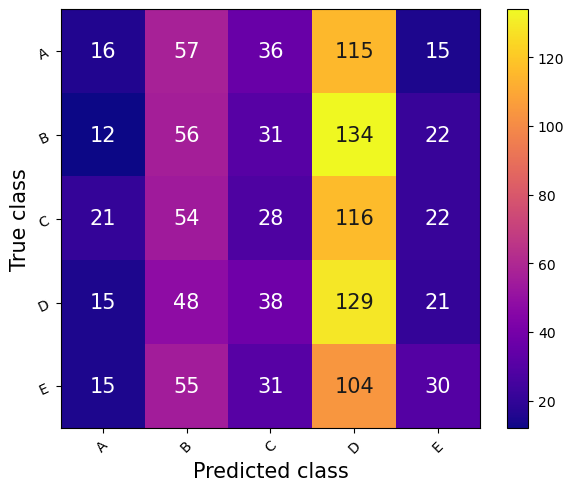

In [41]:
cm = torchmetrics.ConfusionMatrix("multiclass", num_classes=5)
cm.update(predictions, labels)
fig, ax = cm.plot(labels=["A", "B", "C", "D", "E"], cmap="plasma")
cbar = fig.colorbar(ax.images[0], ax=ax)
plt.show()

#### Result description

* The model produces an accuracy of **21.21%**
* Class *D* is heavily overpredicted
* Only class *B* gets a fair shore of the other predictions
* For no class the most predictions are matching with the actual labels

#### Error analysis

In [42]:
misclassified_indices = np.where(predictions != labels)[0]

error_collection = []
for index in misclassified_indices:
    probs = nn.functional.softmax(logits[index], dim=-1)
    probs = probs.numpy()
    top3_indices = np.argsort(probs)[::-1][:3]
    top3_probs = probs[top3_indices]
    
    error_collection.append({
        "Index": index,
        "True Label": labels[index].numpy(),
        "Predicted Label": predictions[index].numpy(),
        "Confidence": probs[predictions[index]],
        "Top-1 Class": top3_indices[0],
        "Top-1 Prob": top3_probs[0],
        "Top-2 Class": top3_indices[1],
        "Top-2 Prob": top3_probs[1],
        "Top-3 Class": top3_indices[2],
        "Top-3 Prob": top3_probs[2],
    })

pd.set_option("display.precision", 3)
df_errors = pd.DataFrame(error_collection)
df_errors.sort_values(by='Confidence', ascending=False, inplace=True)
df_errors.head(10)

,Index,True Label,Predicted Label,Confidence,Top-1 Class,Top-1 Prob,Top-2 Class,Top-2 Prob,Top-3 Class,Top-3 Prob
832,1044,1,3,0.217,3,0.217,2,0.205,4,0.202
542,678,2,3,0.215,3,0.215,2,0.208,1,0.197
252,321,0,2,0.215,2,0.215,3,0.201,1,0.199
352,439,0,3,0.215,3,0.215,1,0.201,2,0.196
98,130,3,1,0.214,1,0.214,3,0.204,0,0.198
270,343,1,3,0.214,3,0.214,2,0.199,1,0.198
300,380,0,1,0.214,1,0.214,3,0.205,2,0.198
891,1123,4,1,0.214,1,0.214,3,0.204,4,0.200
341,426,0,2,0.214,2,0.214,3,0.198,1,0.197
569,710,3,1,0.214,1,0.214,0,0.204,3,0.198


#### Key findings

* The maximum confidence when making wrong predictions at *21.7%* is rather low, the model is therefore not confidently making wrong predictions
* The maximum confidence of wrong predictions is in the range of the actual accuracy of the model
* The true label is often also not in the top-2 predictions
* About half of the time, the true label is in the top-3 predictions 

In [57]:
def get_semantic_analysis(df_errors, hf_dataset):
    INDEX_KEY_MAPPING = {
        0: "A",
        1: "B",
        2: "C",
        3: "D",
        4: "E",
    }

    for _, row in df_errors.head(5).iterrows():
        index = row["Index"]
        true_label = row["True Label"]
        predicted_label = row["Predicted Label"]

        print(f"Predicted: {INDEX_KEY_MAPPING.get(int(predicted_label))}")
        print(f"Ground Truth: {INDEX_KEY_MAPPING.get(int(true_label))}")
        print(f"Q: {hf_dataset[index]['question']}")
        print("\n".join(f"{INDEX_KEY_MAPPING.get(i)}: {a}" for i, a in enumerate(hf_dataset[index]["choices"]["text"])))
        print("\n")

In [58]:
get_semantic_analysis(df_errors, test)

Predicted: D
Ground Truth: B
Q: The tiger was stuck in what animal prison where he got lazy and fat?
A: jungle
B: zoo
C: kill
D: india
E: eat cake


Predicted: D
Ground Truth: C
Q: What can disease destroy?
A: rug
B: third world country
C: human body
D: hospital
E: building


Predicted: C
Ground Truth: A
Q: Sarah dropped the marble because she wanted to do what?
A: game
B: pouch
C: home
D: store
E: jar


Predicted: D
Ground Truth: A
Q: If it is Chrismas time what came most recently before?
A: halloween
B: summer
C: easter
D: kwaanza
E: give gift


Predicted: B
Ground Truth: D
Q: Playing baseball is a lot like any other sport, there is always a risk of what?
A: sore muscles
B: errors
C: happiness
D: injury
E: fun




## Interpretation

It seems like the model does not have the capacity to accurately and confidently predict the correct answer to a question. As can be seen in the confusion matrix, the model overpredicts class *B* very often and neglects class *A* heavily. This seems to be an inherent bias and cannot simply be explained with a lack of capacity. 

In the semantic analysis it can be seen that often times, the model is predicting "in the right direction". It has a grasp of what semantic class a word belongs to and predicts rarely something that does not make sense at all.

Overall, this model is not suited to complete the task of question answering.

# 2. Architecture: RNN+Classifier
## WordEmbeddings &rarr; RNN &rarr; Classifier

## Model

#### Network architecture (layers, dims, nonlinearities, regularizations, normalizations, classifier)

* **Layers**
    * Two GRU layers and two linear layers. Reason:
        * Required in assignment
        * GRU chosen over LSTM because they have similar performance, but GRU has less trainable weights, which makes model smaller
    
* **Dimensions**
    * First GRU Layer: `input_dim = 300`, `hidden_dim = 256`. Reason:
        * This must match the size of the embedding vectors
    * Second GRU Layer: `input_dim = 256`, `hidden_dim = 256`. Reason:
        *  This was determined to be the best hidden dimension for the GRU using hyperparameter sweeps
    * First layer: `input_dim = 2560`, `output_dim = 4096`. Reason:
        * These were determined through hyperparameter sweeps
        * The model is bidirectional therefore the input dimension is `2 * hidden_dim_gru * num_classes`
        * Output dim determined through hyperparameter sweeps
    * Second Layer: `input_dim = 4096`, `output_dim = 5`. Reason: 
        * Input dim must match output dim of layer 1
        * Output dim given from problem to be solved with 5 classes
                
* **Nonlinearities**
    * RELU-nonlinearity in between the two layers. Reason:
        * Required in assignment

* **Regularizations**
    * Dropout with probability of `p = 0.3` between GRU layers. Reason:
        * First model version was heavily overfitting, therefore more regularization added
    * Dropout with probability of `p = 0.3` after output activation of first classification layer. Reason:
        * First model version was heavily overfitting, therefore increase dropout in classifier
        * Ensure some information redundancy in hidden layer of classifier
        * Best probability determined in hyperparameter sweeps
 
* **Normalizations**
    * BatchNormalization was used before classifier input. Reason:
        * After consultation with ChatGPT on what could be improved in my model, it suggested to add Normalization before the Classifier input for added regularization
        * The validation accuracy was jumping around a lot in the first model version, I hoped normalized input would help the classifier

* **Classifier**
    * A multiclass classifier was used. Reason:
        * The task is inherently a multiclass classification task with 5 classes
        * The model was expected to perform better having to choose one class given the information of all classes at once instead of binary classification with only information of the question and one answer at a time.
        * Comparability to classifier architecture

In [60]:
class RNNClassifier(Classifier):
    def __init__(
            self, 
            input_dim: int = 300, 
            hidden_dim_gru: int = 256,
            hidden_dim_linear: int = 4096, 
            output_dim: int = 5, 
            bidirectional: bool = True,
            num_gru_layers: int = 2,
            dropout_cls: float = 0.3,
            dropout_gru: float = 0.3
    ):
        self.num_directions = 2 if bidirectional else 1
        self.num_gru_layers = num_gru_layers
        self.output_dim = output_dim
        super().__init__(
            input_dim=hidden_dim_gru * self.num_directions * self.output_dim, 
            hidden_dim=hidden_dim_linear, 
            output_dim=output_dim,
            dropout=dropout_cls,
        )
        self.norm = nn.BatchNorm1d(output_dim * hidden_dim_gru * self.num_directions)
        self.gru = nn.GRU(input_dim, hidden_dim_gru, num_layers=2, batch_first=True, bidirectional=bidirectional, dropout=dropout_gru)
        
    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        batch_size, num_choices, seq_len, emb_dim = x.shape
    
        lengths, perm_idx = lengths.sort(descending=True)
        x = x[perm_idx]
        x = x.view(batch_size * num_choices, seq_len, emb_dim)
        lengths = lengths.to("cpu").type(torch.int64)
        packed_x = nn.utils.rnn.pack_padded_sequence(x, lengths.repeat_interleave(num_choices), batch_first=True)
    
        h0 = torch.zeros(self.num_gru_layers * self.num_directions, batch_size * num_choices, self.gru.hidden_size).to(
            x.device)
    
        _, hn = self.gru(packed_x, h0)
        fnn_in = hn[-self.num_directions:, :, :].transpose(0, 1).flatten(-2, -1).view(batch_size, -1)
        fnn_in = self.norm(fnn_in)
        out = super().forward(fnn_in)
        perm_out = torch.empty_like(out)
        perm_out[perm_idx] = out
        return perm_out
    
    def reset_parameters(self):
        super().reset_parameters()
        self.gru.reset_parameters()
        

## Training

#### Loss, optimizer
* **Loss function**: CrossEntropyLoss. Reason:
    * Architecture is designed as a multiclass classifier

* **Optimizer**: Adam. Reason:
    * Hyperparameter tuning showed, Adam is better suited than AdamW
    * Adaptive learning rates based on gradients

#### Experiment design (model/optimizer/loss variants, hyperparameters)

* **Model/Optimizer/Loss variants**: Two model architectures were tried:
    * Architecture 1: Concatenation of all answer embedding to the question separated by separator embeddings. Reason:
        * Very easy to implement
        * Seemed like a sensible way to tackle the problem
    * Architecture 2 (final): Each answer embedding separately concatenated to question embeddings with separator embedding inbetween. Reason:
        * Bad performance of first model architecture
        * Every final hidden state has same amount of time steps encoded
    * Loss was not varied. Reason: 
        * CrossEntropyLoss is only meaningful loss function for this problem
    * Regularization was heavily varied. Reason:
        * First model of architecture 2 was heavily overfitting
        * Dropout ond GRU was tried
        * Batch normalization between GRU and classifier was tried
    * Both *Adam* and *AdamW* were used as optimizers. Reason:
        * Past good experience with *AdamW* optimizer
        * ChatGPT suggested, I should also try *Adam* optimizer, which could perform better on smaller datasets

* **Hyperparameters**: The following parameters were chosen for the baseline model
    * learning rate: 1e-4
    * optimizer: *Adam*
    * hidden dimension classifier: 2048
    * hidden dimension gru: 512
    * bidirectional: True
    * training epochs: 100
    * dropout classifier: 0.2
    * dropout gru: 0.2
    * weight decay: 1e-5
    * scheduler start percentage: 0.1
    * **Goal**: Maximize validation accuracy
    * Reason:
        * Maximizing validation accuracy was chosen because as many questions as possible should be answered correctly, no matter how wrong the others are
        * Initial hyperparameters were defined using suggestions from ChatGPT after showing it the model architecture, explaining the input format and the dataset in use

#### Number of training runs

* 1 run on baseline model. Reason:
    * Have comparable result on hyperparameters that were deemed good at implementation time
 
* 30 runs in first broad sweep. Tuning [`optimizer`, `learning_rate`, `hidden_dim classifier`, `hidden_dim gru`, `bidirectional`, `dropout classifier`, `dropout gru`, `weight_decay`]. Reason:
    * Broad range of values around baseline model parameters to tune in on most promising ranges
    * 30 runs give a good insight on which hyperparameters have high importance and what ranges are sensible
    * Sweep using *random* method because validation accuracy spikes a lot for a single epoch and bayes would focus on these runs
* 50 runs in second narrow sweep. Tuning [`learning_rate`, `hidden_dim_classifier`,  `hidden_dim_gru`, `dopout_classifier`, `dropout_gru`, `weight_decay`]. Reason:
    * One model in first sweep showed like it was learning without overfitting heavily
    * Choose paramters above and below the parameters of this run

#### Model checkpointing

* Best and last epoch for every run is checkpointed. Reason:
    * Keep best run for possible later test set evaluation
    * Keep last run for possible later elongated training or fine-tuning
* Checkpointing was made with pytorch_lightning locally. Reason:
    * Did not know that wandb could handle this too
    * Will use wandb for checkpointing the next time to not have checkpoint files locally

#### Early stopping

* Early stopping after 30 epochs of no improvement on validation accuracy. Reason:
    * Do not waste computation
    * Model accuracy was seen to further deteriorate after more than 30 epochs of no improvement

#### Sweeps

* Two sweeps, one broad sweep and one narrow sweep. Reason:
    * Determined to be the most efficient method of hyperparameter optimization
    * *random* sweep was used, because *bayes* focuses too heavily on outliers in validation accuracy
    * Refer to the wandb project report for more information on the sweeps

#### Training routine

Define the function **train_rnn_plus_classifier** which describes the training routine for the classifier model using the **Trainer** class of *lightning* 

In [61]:
def train_rnn_plus_classifier(config, logger, *callbacks):
    L.seed_everything(42)
    model = CqaModule(
        RNNClassifier(
            hidden_dim_gru=config.get("hd_gru"),
            hidden_dim_linear=config.get("hd_cls"),
            bidirectional=config.get("bidirectional"),
            dropout_cls=config.get("drp_cls"),
            dropout_gru=config.get("drp_gru"),
        ),
        nn.CrossEntropyLoss,
        **config
    )
    trainer = L.Trainer(
        max_epochs=config.get("epochs"),
        accelerator="auto",
        devices=1,
        callbacks=list(callbacks),
        logger=logger,
    )
    trainer.fit(model, train_loader_rnn, valid_loader_rnn)

Define run parameters

In [62]:
MODEL_NAME = "RNN+Classifier_Baseline"
config = dict(
    lr=1e-4,
    optim="Adam",
    hd_cls=2048,
    hd_gru=512,
    bidirectional=True,
    epochs=100,
    steps_per_epoch=len(train_loader_rnn),
    drp_cls=0.2,
    drp_gru=0.2,
    wd=1e-5,
    pct_start=0.1,
)

#### Checkpointing

In [63]:
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    dirpath="./lightning_checkpoints",
    filename=get_run_name(MODEL_NAME) + "-{epoch:02d}-{valid_acc:.2f}",
    monitor="valid_acc",
    save_last=True,
    mode="max"
)

#### Early stopping

In [64]:
early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
    monitor="valid_acc",
    patience=30,
    mode="max"
)

Initialize wandb experiment tracking for run


In [ ]:
with wandb.init(
    entity="david-schurtenberger",
    project="NLP_Project_1",
    name=get_run_name(MODEL_NAME),
    config=config,
) as run:
    wandb_logger = WandbLogger(project="NLP_Project_1")
    train_rnn_plus_classifier(run.config, wandb_logger, checkpoint_callback, early_stopping_callback)

### Hyperparameter tuning

In [65]:
MODEL_NAME = "RNN+Classifier"
def rnn_sweep(config=None):
    with wandb.init(config=config) as run:
        config = wandb.config
        run.name = get_run_name(MODEL_NAME)
        checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
            dirpath="./lightning_checkpoints",
            filename=get_run_name(MODEL_NAME) + "-{epoch:02d}-{valid_acc:.2f}",
            monitor="valid_acc",
            save_last=True,
            mode="max"
        )
        early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
            monitor="valid_acc",
            patience=30,
            mode="max"
        )
        wandb_logger = WandbLogger(log_model=True)
        train_rnn_plus_classifier(config, wandb_logger, checkpoint_callback, early_stopping_callback)

Broad sweep

In [66]:
broad_sweep_parameters = {
        "lr": {"values": [1e-4, 1e-3]},
        "optim": {"values": ["Adam", "AdamW"]},
        "hd_cls": {"values": [1024, 2048, 4096]},
        "hd_gru": {"values": [256, 512, 1024]},
        "bidirectional": {"values": [True, False]},
        "wd": {"values": [0, 1e-5, 1e-4, 1e-3]},
        "drp_cls": {"values": [0.0, 0.2, 0.4, 0.5]},
        "drp_gru": {"values": [0.0, 0.2, 0.4, 0.5]},
        "pct_start": {"values": [0.1, 0.2, 0.3]},
        "epochs": {"value": 100},
        "steps_per_epoch": {"value": len(train_loader_rnn)},
    }

In [67]:
narrow_sweep_parameters = {
        "lr": {"values": [1e-4, 1e-3]},
        "optim": {"value": "Adam"},
        "hd_cls": {"values": [4096, 8192]},
        "hd_gru": {"values": [256, 512]},
        "bidirectional": {"value": True},
        "wd": {"values": [1e-5, 1e-3]},
        "drp_cls": {"values": [0.1, 0.2, 0.3]},
        "drp_gru": {"values": [0.1, 0.2, 0.3]},
        "pct_start": {"value": 0.1},
        "epochs": {"value": 100},
        "steps_per_epoch": {"value": len(train_loader_rnn)},
    }

In [68]:
sweep_config = {
    "name": "RNN+ClassifierSweep_V2_Narrow",
    "method": "random",
    "metric": {"name": "max_valid_acc", "goal": "maximize"},
    "parameters": narrow_sweep_parameters,
}

In [ ]:
sweep_id = wandb.sweep(
    sweep=sweep_config, 
    entity="david-schurtenberger",
    project="NLP_Project_1",
)

In [ ]:
wandb.agent(sweep_id=sweep_id, function=rnn_sweep, count=50)

In [ ]:
wandb.api.stop_sweep(sweep_id)

Choose best model from hyperparameter sweeps and load checkpoint at peak validation accuracy. For the selection of the best model refer to the *wandb project report*

In [69]:
checkpoint_path = "lightning_checkpoints/RNN+Classifier_250406214953-epoch=79-valid_acc=0.23.ckpt"

## Evaluation

Load the best classifier model from its checkpoint with the hyperparameters of its run

In [70]:
rnn_model = CqaModule.load_from_checkpoint(checkpoint_path, model=RNNClassifier(), loss_function=nn.CrossEntropyLoss)

Run evaluation on the test set and save the predictions, the logits of each prediction and the true labels

In [71]:
def evaluate_model(model, dataloader) -> tuple[np.array, np.array, np.array]:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    predictions, logits, true_labels = [], [], []

    with torch.no_grad():
        for inputs, lengths, labels in dataloader:
            inputs = inputs.to(device)
            lengths = lengths.to(device)
            l = model(inputs, lengths)
            l = l.to("cpu")
            preds = torch.argmax(l, dim=-1)

            logits.append(l)
            predictions.append(preds)
            true_labels.append(labels)

    return torch.cat(predictions), torch.cat(logits), torch.cat(true_labels)

In [72]:
predictions, logits, labels = evaluate_model(rnn_model, test_loader_rnn)

Accuracy on test set

In [73]:
acc = torchmetrics.Accuracy("multiclass", num_classes=5)
acc.update(predictions, labels)
print(f"Test Accuracy: {acc.compute():.2%}")

Test Accuracy: 20.88%


Confusion Matrix

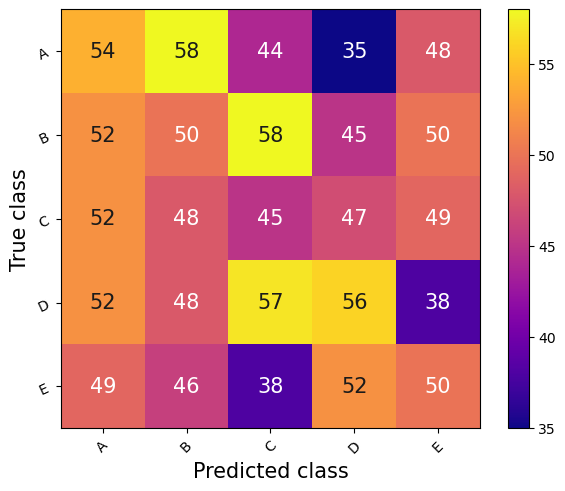

In [74]:
cm = torchmetrics.ConfusionMatrix("multiclass", num_classes=5)
cm.update(predictions, labels)
fig, ax = cm.plot(labels=["A", "B", "C", "D", "E"], cmap="plasma")
cbar = fig.colorbar(ax.images[0], ax=ax)
plt.show()

#### Result description

* The model has an accuracy of **20.88%**
* The model overpredicts classes *A* and *B*
* Classes *A*, *D* and *E* have the most predictions when it is actually the correct class
* The model seems to predict every class at an approximately equal amount
* Only for true class *D* the model also has the most predictions at class *D*

#### Error analysis

In [75]:
misclassified_indices = np.where(predictions != labels)[0]

error_collection = []
for index in misclassified_indices:
    probs = nn.functional.softmax(logits[index], dim=-1)
    probs = probs.numpy()
    top3_indices = np.argsort(probs)[::-1][:3]
    top3_probs = probs[top3_indices]
    
    error_collection.append({
        "Index": index,
        "True Label": labels[index].numpy(),
        "Predicted Label": predictions[index].numpy(),
        "Confidence": probs[predictions[index]],
        "Top-1 Class": top3_indices[0],
        "Top-1 Prob": top3_probs[0],
        "Top-2 Class": top3_indices[1],
        "Top-2 Prob": top3_probs[1],
        "Top-3 Class": top3_indices[2],
        "Top-3 Prob": top3_probs[2],
    })

pd.set_option("display.precision", 3)
df_errors = pd.DataFrame(error_collection)
df_errors.sort_values(by='Confidence', ascending=False, inplace=True)
df_errors.head(10)

,Index,True Label,Predicted Label,Confidence,Top-1 Class,Top-1 Prob,Top-2 Class,Top-2 Prob,Top-3 Class,Top-3 Prob
491,617,2,3,0.439,3,0.439,2,0.157,4,0.149
80,103,4,2,0.434,2,0.434,0,0.195,4,0.151
324,404,2,1,0.416,1,0.416,0,0.200,2,0.153
929,1173,0,2,0.416,2,0.416,1,0.194,3,0.160
180,236,0,4,0.409,4,0.409,3,0.218,2,0.130
607,765,3,1,0.406,1,0.406,3,0.224,2,0.128
692,873,3,0,0.401,0,0.401,3,0.185,1,0.150
112,143,0,3,0.398,3,0.398,2,0.196,1,0.185
823,1032,4,2,0.388,2,0.388,0,0.188,3,0.163
176,230,2,4,0.384,4,0.384,2,0.257,0,0.137


#### Key findings
* The maximum confidence of wrong predictions is higher than for the classifier model
* The model has a peak confidence for wrong predictions of 43.4%
* For about two thirds of the wrong predictions shown, the true class is in the top-3 probabilities
* The Lowest top-three probability for wrong predictions with highest confidence is 12.8%

In [76]:
def get_semantic_analysis(df_errors, hf_dataset):
    INDEX_KEY_MAPPING = {
        0: "A",
        1: "B",
        2: "C",
        3: "D",
        4: "E",
    }

    for _, row in df_errors.head(5).iterrows():
        index = row["Index"]
        true_label = row["True Label"]
        predicted_label = row["Predicted Label"]

        print(f"Predicted: {INDEX_KEY_MAPPING.get(int(predicted_label))}")
        print(f"Ground Truth: {INDEX_KEY_MAPPING.get(int(true_label))}")
        print(f"Q: {hf_dataset[index]['question']}")
        print("\n".join(f"{INDEX_KEY_MAPPING.get(i)}: {a}" for i, a in enumerate(hf_dataset[index]["choices"]["text"])))
        print("\n")

In [77]:
get_semantic_analysis(df_errors, test)

Predicted: D
Ground Truth: C
Q: For many males hair is a concern as they get older, it begins to what, causing a receding hairline?
A: thin out
B: grow in ear
C: fall out
D: bulge
E: composted


Predicted: C
Ground Truth: E
Q: An underrated thing about computers is how they manage workflow, at one time it was a big deal when they could first do what?
A: share files
B: do arithmetic
C: turn on
D: cost money
E: multitask


Predicted: B
Ground Truth: C
Q: Sarah didn't like to play but she didn't want to be sedentary and bored, either, so she took up what?
A: serious
B: longplay
C: musical
D: eat cake
E: doing nothing


Predicted: C
Ground Truth: A
Q: No matter what date you put on it, we all know the universe to be what?
A: very old
B: infiniverse
C: getting younger
D: infinite
E: real


Predicted: E
Ground Truth: A
Q: A car was hailed to chauffeur someone to the opera house, where was it heading?
A: go downtown
B: appear suddenly
C: go fast
D: bottom out
E: east




## Interpretation

The overfitting of previous model versions has been mostly eliminated. Although the test accuracy is lower than the one of the Classifier model, this model has a more even spread of predictions and does not only focus on a single class.

In the semantic analysis - which can be quite humorous - it becomes apparent that the model has learnt some things about semantics. For example it has learnt that the universe is related to age, even though it was predicted to be getting younger. Or it knows that a car heading somewhere has something to do with direction. The prediction of it going east is somewhat inexplainable, but still better than choosing for example bottom out.

All in all, similar to the Classifier model, this implementation is unusable for question answering.

## Tools and References

The following tools were used in the process of creating this notebook:
* PyCharm (IDE)
* gpuhub (cloud GPU)
* ChatGPT (research and debugging)
* Weights & Biases (experiment tracking)
  
* [pytorch documentation](https://pytorch.org/docs/stable/index.html)
* [pytorch lightning documentation](https://lightning.ai/docs/pytorch/stable/)
* [wandb documentation](https://docs.wandb.ai/https://docs.wandb.ai/)
* [torchmetrics documentation](https://lightning.ai/docs/torchmetrics/stable/)